In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.volatility import BollingerBands
from pykalman import KalmanFilter
from pmdarima import auto_arima
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, TimeDistributed, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from pykalman import KalmanFilter
import gym
import gym.spaces
import stable_baselines3 as sb3
from stable_baselines3 import PPO
from skopt import gp_minimize
from skopt.space import Integer, Real
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from ta.volatility import BollingerBands


In [6]:
# Step 1: Download the data
data = yf.download('^GSPC', start='2010-01-01', end='2025-04-12')

# Step 2: Compute indicators
data['SMA_crossover'] = data['Close'].rolling(window=200).mean() - data['Close'].rolling(window=50).mean()

def stochastic_oscillator(df, window=14):
    low_min = df['Low'].rolling(window).min()
    high_max = df['High'].rolling(window).max()
    df['%K'] = 100 * ((df['Close'] - low_min) / (high_max - low_min))
    return df

data = stochastic_oscillator(data)

def average_true_range(df, window=14):
    high_low = df['High'] - df['Low']
    high_close = abs(df['High'] - df['Close'].shift(1))
    low_close = abs(df['Low'] - df['Close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR_14'] = true_range.rolling(window).mean()  # SMA of TR
    return df

data = average_true_range(data)  

def on_balance_volume(df):
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).cumsum()
    return df

data = on_balance_volume(data)  # Adds OBV column

def vwap(df):
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
    return df

data = vwap(data)  # Adds VWAP column

delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI_14'] = 100 - (100 / (1 + rs))

ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26

data['Return'] = data['Close'].pct_change()
data['Volatility'] = data['Return'].rolling(window=10).std()

bb_indicator = BollingerBands(close=data['Close'].squeeze(), window=20, window_dev=2)
data['BB_bandWidh'] = bb_indicator.bollinger_hband() - bb_indicator.bollinger_lband()

data['Return_3'] = data['Close'].pct_change(3).shift(1)  # 3-day cumulative return
data['Return_5'] = data['Close'].pct_change(5).shift(1)  # 5-day cumulative return
data['SMA_17'] = data['Close'].rolling(window=17).mean()
data['SMA_5'] = data['Close'].rolling(window=5).mean()
data['SMA_9'] = data['Close'].rolling(window=9).mean()
data['SMA_crossover_binary'] = (data['Close'].rolling(window=10).mean() > data['Close'].rolling(window=50).mean()).astype(int)

data['Volatility_Trend'] = data['Volatility'] - data['Volatility'].shift(1)

data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_Histogram'] = data['MACD'] - data['MACD_Signal']

kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=data['Close'].shift(-3).values[0],
    initial_state_covariance=1.0,
    observation_covariance=1.0,
    transition_covariance=0.1
)
data['Target'], _ = kf.filter(data['Close'].shift(-3).values)

y = data['Target'].values.reshape(-1, 1)
data.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed


In [7]:

features = ['SMA_crossover','SMA_17' ,'SMA_9','SMA_5','ATR_14', 'OBV', 'VWAP','Volume','BB_bandWidh','MACD','Volatility']
X = data[features].values
y = data['Target'].values.reshape(-1, 1)

# Step 6: Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)
sequence_length =3
# Step 7: Sequence formatting for LSTM-like models
X_reshaped = np.array([X_scaled[i-sequence_length:i] for i in range(sequence_length, len(X_scaled))])
y_reshaped = y_scaled[sequence_length:]

split = int(0.9 * len(X_reshaped))
X_train_t, X_test = X_reshaped[:split], X_reshaped[split:]
y_train_t, y_test = y_reshaped[:split], y_reshaped[split:]

split = int(0.9 * len(X_train_t))
X_train, X_val = X_train_t[:split], X_train_t[split:]
y_train, y_val = y_train_t[:split], y_train_t[split:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Final sanity check
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

num_features = X_train.shape[2]  # e.g., 12



X_train shape: (2946, 3, 11)
y_train shape: (2946, 1)
X_val shape: (328, 3, 11)
y_val shape: (328, 1)
X_test shape: (364, 3, 11)
y_test shape: (364, 1)


Creating LSTM model with units: 64 and dropout rate: 0.2 for sequence length: 3 and num features: 11
Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0541 - mae: 0.1720
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0119 - mae: 0.0873
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0026 - mae: 0.0399
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - mae: 0.0281
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - mae: 0.0259
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - mae: 0.0260
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - mae: 0.0260
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011 - mae: 0.0249
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - mae: 0.0234
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0010 - mae: 0.0230
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - mae: 0.0235
Epoch 12/50
93/93

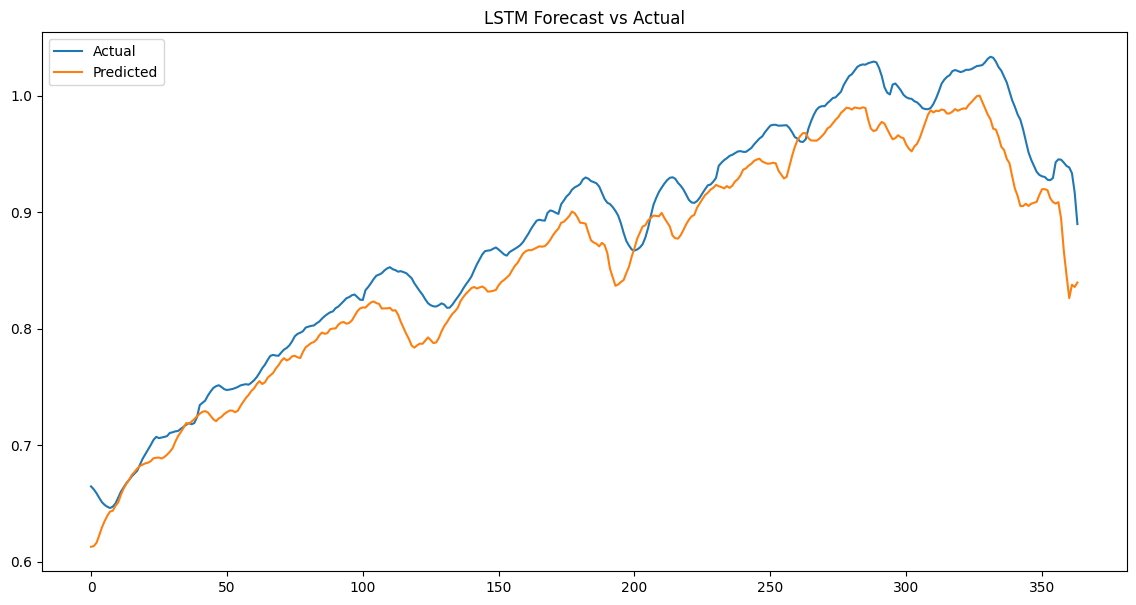

In [93]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        query, value = inputs, inputs
        score = tf.matmul(query, tf.transpose(value, [0, 2, 1]))
        attention_weights = tf.nn.softmax(score, axis=-1)
        context_vector = tf.matmul(attention_weights, value)
        return context_vector

def create_lstm_model(units, dropout_rate, sequence_length, num_features):
    print("Creating LSTM model with units:", units, "and dropout rate:", dropout_rate, "for sequence length:", sequence_length, "and num features:", num_features)
    inputs = Input(shape=(sequence_length, num_features))
    x = LSTM(units, kernel_initializer='glorot_uniform', return_sequences=True)(inputs)
    x = AttentionLayer()(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


sequence_length = 3
num_features = X_train.shape[2]  # e.g., 12

lstm_model = create_lstm_model(units=64, dropout_rate=0.2,
                               sequence_length=sequence_length,
                               num_features=num_features)

lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
                callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                           ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)])


preds = lstm_model.predict(X_test)

plt.figure(figsize=(14, 7),dpi=100)
plt.plot(preds, label='Actual')
plt.plot(y_test, label='Predicted')
plt.legend()
plt.title("LSTM Forecast vs Actual")
plt.show()


In [94]:
def generate_true_trends_without_treshold(prices, threshold=0.001):
    """Convert price changes into discrete trend labels (0:UP, 1:DOWN, 2:NEUTRAL)."""
    trends = []
    threshold = 0.005
    for i in range(1, len(prices)-1):
        diff = prices[i + 1] - prices[i]
        if diff > threshold:
            trends.append(0)  # UP
        elif diff < -threshold:
            trends.append(1)  # DOWN
        else:
            trends.append(2)  # NEUTRAL
    return trends



In [95]:
# For LSTM predictions or actual prices

preds = lstm_model.predict(X_test)
preds_rescaled = scaler_y.inverse_transform(preds)
y_true = scaler_y.inverse_transform(y_test)

all_true_trends = generate_true_trends_without_treshold(y_test)  # 363 trends for 364 prices
all_true_pred = generate_true_trends_without_treshold(preds)  # 363 trends for 364 prices
print(np.bincount(all_true_trends))
print(np.bincount(all_true_pred))
# 7. Evaluate the model

from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(all_true_trends, all_true_pred)
print(f"Accuracy: {accuracy:.3f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_true_trends, all_true_pred, 
                           target_names=['UP', 'DOWN', 'NEUTRAL']))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[ 26  31 305]
[ 25  21 316]
Accuracy: 0.746

Classification Report:
              precision    recall  f1-score   support

          UP       0.04      0.04      0.04        26
        DOWN       0.19      0.13      0.15        31
     NEUTRAL       0.84      0.87      0.85       305

    accuracy                           0.75       362
   macro avg       0.36      0.35      0.35       362
weighted avg       0.73      0.75      0.74       362



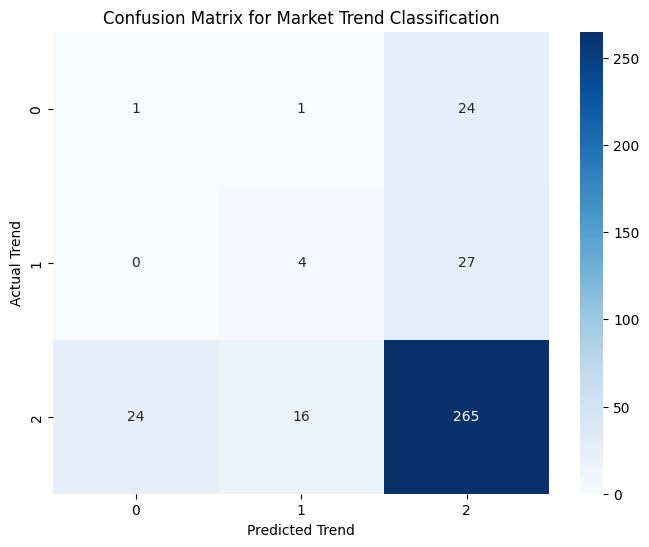

              precision    recall  f1-score   support

        Down       0.04      0.04      0.04        26
     Neutral       0.19      0.13      0.15        31
          Up       0.84      0.87      0.85       305

    accuracy                           0.75       362
   macro avg       0.36      0.35      0.35       362
weighted avg       0.73      0.75      0.74       362



In [97]:
import pandas as pd
from sklearn.metrics import classification_report
# Step 8: Visualization - Confusion Matrix
plt.figure(figsize=(8, 6))
conf_mat = pd.crosstab(
    pd.Series(all_true_trends, name='Actual'),
    pd.Series(all_true_pred, name='Predicted')
)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Market Trend Classification')
plt.xlabel('Predicted Trend')
plt.ylabel('Actual Trend')
plt.show()

print(classification_report(all_true_trends, all_true_pred, target_names=['Down', 'Neutral', 'Up']))